In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data Cleaning

In [2]:
sales = pd.read_parquet('sale_sample_18-21.parquet')
township_codes = gpd.read_file('townships.geojson')
char_sample = pd.read_csv('char_sample.csv', dtype={'class': str}) # also has 'EX' in column
geo_info = pd.read_csv('parcels_geoinfo.csv')

sales.year = sales.year.astype(int)
sales.pin = sales.pin.astype(int)
#sales.township = sales.township_code.astype(int)
#townships.township = townships.township.astype(int)
geo_info['class'] = geo_info['class'].astype(str)
geo_info.drop(['year'], axis=1,  inplace=True)
sales['class'] = sales['class'].astype(str)
sales.township_code = sales.township_code.astype(int)
sales = pd.merge(sales, geo_info, on=['pin', 'class'], how='outer')
sales = pd.merge(sales, char_sample, on=['pin', 'year', 'class'])
sales = sales[sales['is_multisale'] != 1]
sales = sales[sales['num_parcels_sale'] == 1] # STOP GAP
sales.rename(columns = {'township_code_x': 'township_code'}, inplace=True)


# Variance - Outlier Detection

Just check number of deivations away from mean grouped by township_code.

Problems:

Would like to vary by geography, but how to join new geographies to table to do that? What is value in common? With spatial dataset could see what PINS in what unit, but we have no lat/long for data.


In [3]:
sales

,pin,year,township_code,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,is_homestead_exemption,homestead_exemption_general_alternative,homestead_exemption_senior_citizens,homestead_exemption_senior_citizens_assessment_freeze,township_code_y,census_tract_geoid,lat,lon,sqft,year_built
0,2092050370000,2019.0,29.0,295,2019-05-01 00:00:00+00:00,201000.0,5.303196,96812985.0,1915417094,01,...,0,0.0,0.0,0.0,29.0,NaN,NaN,NaN,1155.0,1985.0
2,10201120410000,2018.0,24.0,206,2018-07-01 00:00:00+00:00,540000.0,5.732394,97373057.0,1822817046,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2256.0,1947.0
3,16183030040000,2022.0,27.0,203,2022-02-11 00:00:00+00:00,595000.0,5.774517,7321053.0,2206001050,01,...,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1787.0,1918.0
4,10272320440000,2020.0,24.0,203,2020-04-01 00:00:00+00:00,285000.0,5.454845,96592558.0,2019607192,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1332.0,1953.0
6,15011010390000,2020.0,33.0,234,2020-12-29 00:00:00+00:00,480000.0,5.681241,7127160.0,2102855154,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2079.0,1888.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360972,7294030160000,2021.0,35.0,278,2021-08-30 00:00:00+00:00,220000.0,5.342423,7249327.0,2126546039,01,...,0,0.0,0.0,0.0,35.0,1.703180e+10,42.010148,-88.116944,2330.0,1966.0
360973,7262000211004,2018.0,35.0,299,2018-04-01 00:00:00+00:00,173000.0,5.238046,97001692.0,1812729171,01,...,0,0.0,0.0,0.0,35.0,1.703180e+10,42.019659,-88.058596,1550.0,1989.0
360974,7243030171010,2018.0,35.0,299,2018-11-01 00:00:00+00:00,172000.0,5.235528,96594757.0,1831757035,02,...,0,0.0,0.0,0.0,35.0,1.703180e+10,42.022923,-88.042686,1500.0,1979.0
360975,13251310310000,2018.0,77.0,203,2018-05-01 00:00:00+00:00,625000.0,5.795880,96260041.0,1815912107,01,...,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1102.0,1895.0


In [4]:
def is_outlier_groupby(s: pd.Series, lower_lim : int, upper_lim: int) -> pd.DataFrame:
    """
    Finds values outside of std deviation range.
    Function meant for groupby() only.
    """
    lower_limit = s.mean() - (s.std() * lower_lim)
    upper_limit = s.mean() + (s.std() * upper_lim)
    return ~s.between(lower_limit, upper_limit)


def plot_std(group: str, col: str, permuts: list) -> list:
    fig, ax = plt.subplots(figsize=(15,10), ncols=2, nrows=len(permuts))
    stats = []
    outs = {}

    for tup in range(len(permuts)):
        std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
        std_outliers[col].plot.hist(ax=ax[tup, 0] )
        no_std_outliers[col].plot.hist(ax=ax[tup,1])
        fig.suptitle('Outliers - No Outliers')

        pct = len(std_outliers) / len(sales.dropna(subset=[group, col]))
        stat = (len(std_outliers), pct)
        stats.append(stat)
        outs[permuts[tup]] = std_outliers

    print(stats)
    return outs


[(227, 0.006217134092900964), (367, 0.010051489921121823), (423, 0.011585232252410167), (1165, 0.031907318141980716)]


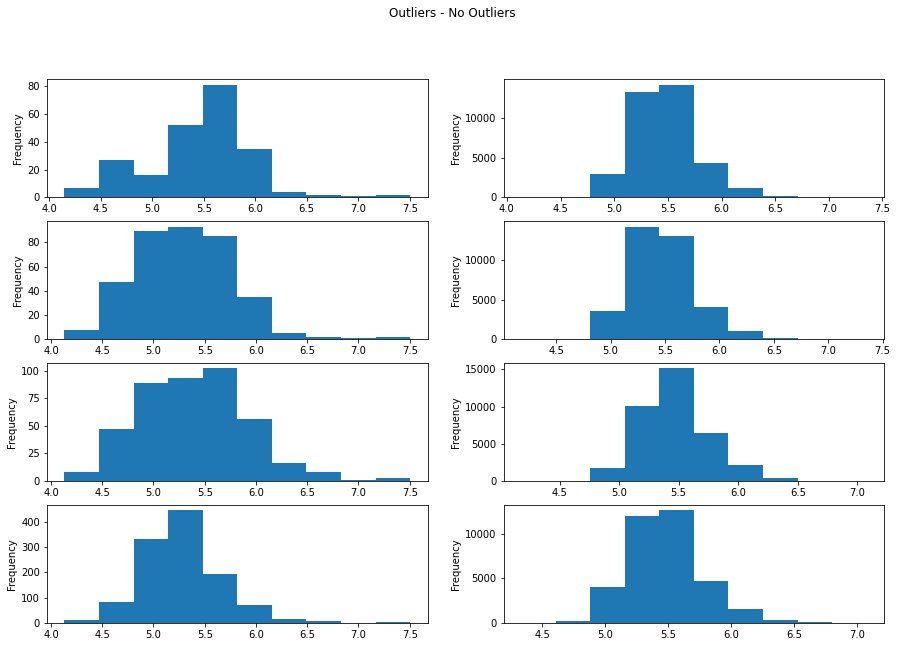

In [5]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
census_sale_outs = plot_std('census_tract_geoid', 'sale_price_log10', std_permutations)

[(912, 0.003051157064331907), (2534, 0.008477666667781856), (2895, 0.009685416339079902), (10410, 0.034827352017209594)]


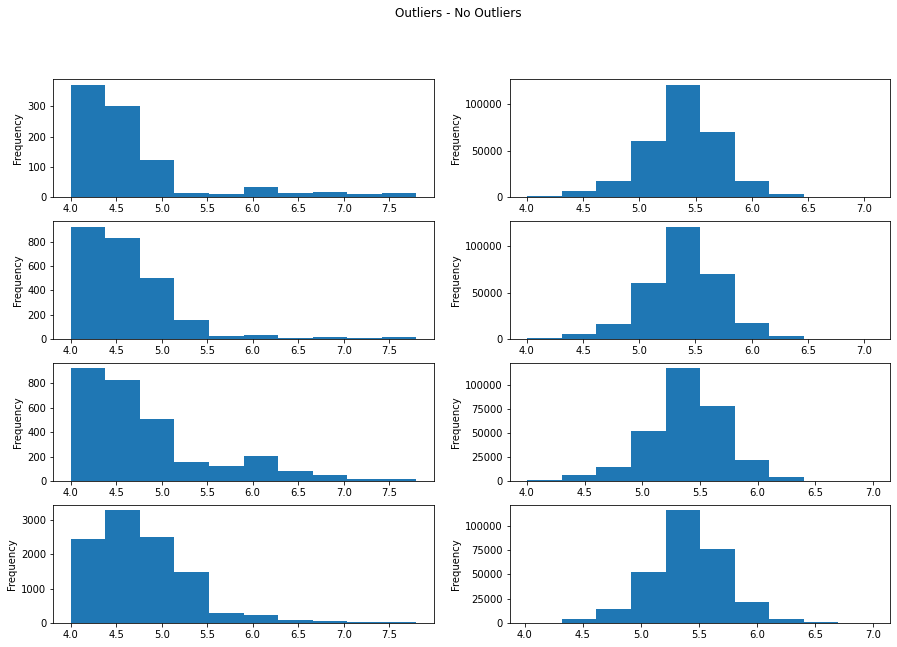

In [6]:
town_sale_outs = plot_std('township_code', 'sale_price_log10', std_permutations)

### $ per sqft

In [7]:
sales['price_per_sqft'] = sales['sale_price'] / sales['sqft']
sales['price_per_sqft_log10'] = sales['sale_price_log10'] / sales['sqft']
sales['price_per_sqft'].replace([np.inf, -np.inf], np.nan, inplace=True)
sales['price_per_sqft_log10'].replace([np.inf, -np.inf], np.nan, inplace=True)

/tmp/ipykernel_607620/2638574784.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class']

[(384, 0.0017345426950457123), (541, 0.0024437177031763815), (1288, 0.005817945289632494), (3749, 0.016934376468037436)]


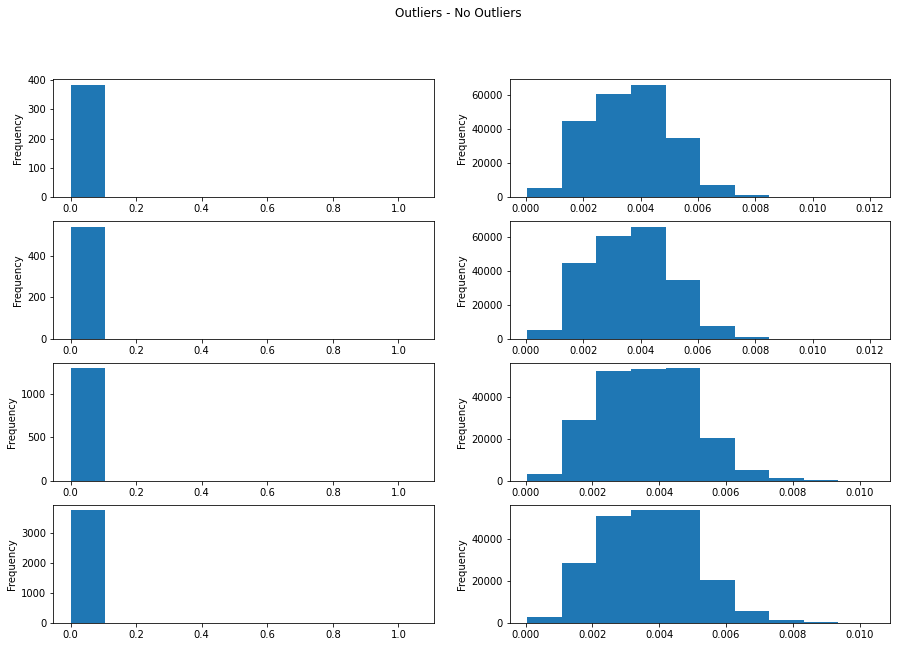

In [8]:
town_sqft_outs = plot_std('township_code', 'price_per_sqft_log10', std_permutations)

/tmp/ipykernel_607620/2638574784.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class']

[(179, 0.0052395866873518136), (195, 0.0057079296314726455), (270, 0.007903287182039049), (643, 0.018821532066855957)]


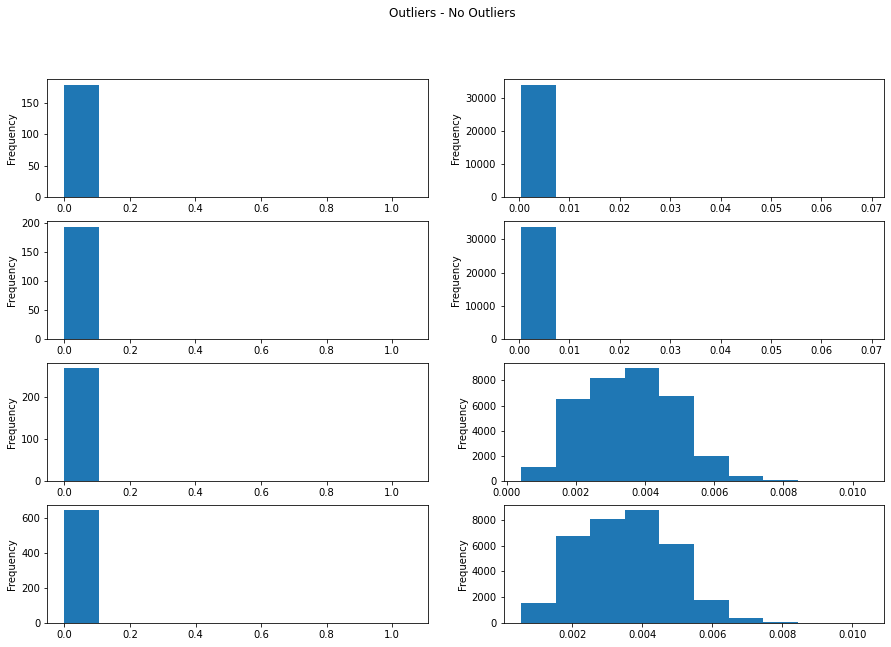

In [9]:
census_sqft_outs = plot_std('census_tract_geoid', 'price_per_sqft_log10', std_permutations)

#### Overlaps

In [10]:
# Between Township and Census for price
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(census_sale_outs[tup]), len(pd.merge(town_sale_outs[tup], census_sale_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 912 227 33
(3, 4) 2534 367 113
(3, 3) 2895 423 138
(2, 3) 10410 1165 541


In [11]:
# Between Township and Census for SQFT
for tup in std_permutations:
    print(tup, len(town_sqft_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(town_sqft_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 384 179 5
(3, 4) 541 195 7
(3, 3) 1288 270 36
(2, 3) 3749 643 133


In [12]:
# Within township for price and price/sqft
for tup in std_permutations:
    print(tup, len(town_sale_outs[tup]), len(town_sqft_outs[tup]), len(pd.merge(town_sale_outs[tup], town_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 912 384 20
(3, 4) 2534 541 45
(3, 3) 2895 1288 82
(2, 3) 10410 3749 507


In [13]:
# Within census for price and price/sqft
for tup in std_permutations:
    print(tup, len(census_sale_outs[tup]), len(census_sqft_outs[tup]), len(pd.merge(census_sale_outs[tup], census_sqft_outs[tup])))
# limits, length of first DF, length of 2nd DF, length of overlap

(4, 4) 227 179 160
(3, 4) 367 195 167
(3, 3) 423 270 183
(2, 3) 1165 643 229


# Sale Volatility

Create buckets of which properties fall into which growth rates. Look at absolute value change, see if departing from value of area or moving towards.
See what portion of data illustrates particular outlier flag, and which ones illustrate several outlier flags.

In [14]:
sales['pct'] = sales.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
township_avg_change = sales.groupby(['township_code'])['pct'].mean()
township_mean = sales.groupby(['township_code'])['sale_price_log10'].mean()

sales.set_index('township_code', inplace=True)
sales['township_avg_change'] = township_avg_change
sales['township_mean_sale_log10'] = township_mean
sales['diff_from_township_mean_sale_log10'] = abs(sales['township_mean_sale_log10'] - sales['sale_price_log10'])
sales.reset_index(inplace=True)

#sales['price_movement'] = 'toward'
#sales.loc[sales['sale_price'] is further away from township mean than last sales price, 'price_movement'] = 'away'

<AxesSubplot:xlabel='township_mean_sale_log10', ylabel='township_avg_change'>

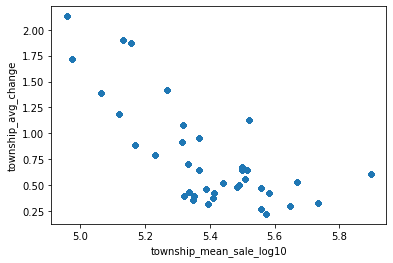

In [15]:
sales.plot.scatter(x='township_mean_sale_log10', y='township_avg_change')

In [16]:
sales[sales['township_code'] == 76]

,township_code,pin,year,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,lat,lon,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
9,76.0,16364000080000,2018.0,211,2018-10-01 00:00:00+00:00,118000.0,5.071882,97299586.0,1831319495,01,...,NaN,NaN,1344.0,1888.0,87.797619,0.003774,NaN,0.460942,5.388322,0.316440
30,76.0,17294270430000,2018.0,211,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,NaN,NaN,1224.0,1894.0,192.810458,0.004390,0.0,0.460942,5.388322,0.015410
31,76.0,17294270430000,2018.0,211,2018-02-01 00:00:00+00:00,236000.0,5.372912,97298082.0,1805841021,01,...,NaN,NaN,1400.0,1864.0,168.571429,0.003838,NaN,0.460942,5.388322,0.015410
78,76.0,17314180080000,2018.0,203,2018-07-01 00:00:00+00:00,265000.0,5.423246,96705202.0,1820718048,01,...,NaN,NaN,1575.0,1888.0,168.253968,0.003443,NaN,0.460942,5.388322,0.034924
117,76.0,17283180210000,2018.0,203,2018-08-01 00:00:00+00:00,385000.0,5.585461,97114308.0,1823612060,01,...,NaN,NaN,1185.0,1983.0,324.894515,0.004713,NaN,0.460942,5.388322,0.197139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298455,76.0,17221050501188,2019.0,299,2019-07-01 00:00:00+00:00,335000.0,5.525045,96591125.0,1919857086,01,...,NaN,NaN,NaN,2008.0,NaN,NaN,NaN,0.460942,5.388322,0.136723
298460,76.0,17103160331045,2019.0,299,2019-11-01 00:00:00+00:00,242500.0,5.384712,97481747.0,1932508202,01,...,NaN,NaN,NaN,2001.0,NaN,NaN,NaN,0.460942,5.388322,0.003610
298730,76.0,17312210040000,2020.0,203,2020-09-16 00:00:00+00:00,310000.0,5.491362,7098657.0,2032507219,01,...,NaN,NaN,1573.0,1893.0,197.075652,0.003491,NaN,0.460942,5.388322,0.103040
298757,76.0,17282110020000,2018.0,212,2018-04-01 00:00:00+00:00,570000.0,5.755875,98336720.0,1810318075,01,...,NaN,NaN,3060.0,1891.0,186.274510,0.001881,NaN,0.460942,5.388322,0.367553


<AxesSubplot:ylabel='Frequency'>

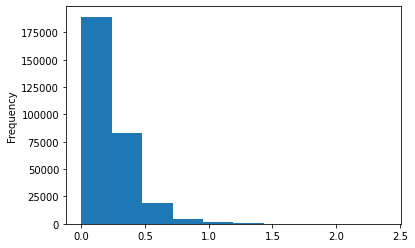

In [17]:
sales.diff_from_township_mean_sale_log10.plot.hist()

<AxesSubplot:ylabel='Frequency'>

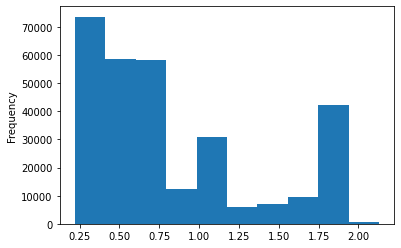

In [18]:
sales.township_avg_change.plot.hist()

## Between transactions for the same property

In [19]:
dups = sales[sales.pin.duplicated(keep=False)]

In [20]:
v_counts = dups.pin.value_counts().reset_index().rename(columns={'index':'pin', 'pin':'counts'})

In [21]:
def is_outlier_column(df: pd.DataFrame, col: str, lower_lim, upper_lim):
    """
    Function that calculates outliers for pandas columns.
    Contrat with is_outlier_groupby().
    """
    lower_limit = df[col].mean() - (df[col].std() * lower_lim)
    upper_limit = df[col].mean() + (df[col].std() * upper_lim)
    return df[~df[col].between(lower_limit, upper_limit)]


In [22]:
count_outliers = {}
for std in std_permutations:
    count_outliers[std] = is_outlier_column(v_counts, 'counts', std[0], std[1])

In [23]:
for tup in std_permutations:
    print(tup, len(count_outliers[tup]))

(4, 4) 182
(3, 4) 182
(3, 3) 182
(2, 3) 182


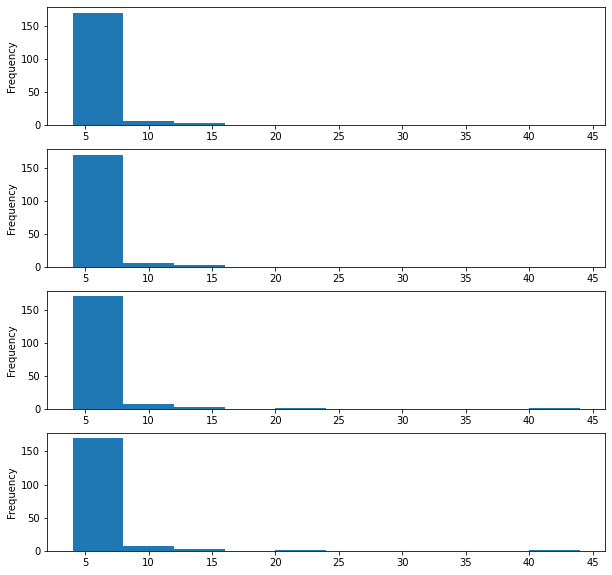

In [24]:
fig, ax = plt.subplots(figsize=(10,10), ncols=1, nrows=len(std_permutations))
for std in range(len(std_permutations)):
    count_outliers[std_permutations[std]].counts.plot.hist(ax=ax[std])

In [25]:
count_outliers[(2,3)]

,pin,counts
0,8121220400000,44
1,17171020430000,20
2,17211330040000,15
3,17341211170000,12
4,17293090360000,12
...,...,...
177,14083040581002,4
178,13152110410000,4
179,20102110380000,4
180,19323210170000,4


/tmp/ipykernel_607620/2638574784.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  std_outliers = sales.dropna(subset=[group, col])[sales.groupby([group, 'class'])[col].apply(is_outlier_groupby, permuts[tup][0], permuts[tup][1])]
/tmp/ipykernel_607620/2638574784.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  no_std_outliers = sales.dropna(subset=[group, col])[~sales.groupby([group, 'class']

[(300, 0.009014152218983804), (308, 0.00925452961149004), (572, 0.017186983564195787), (588, 0.01766773834920826)]


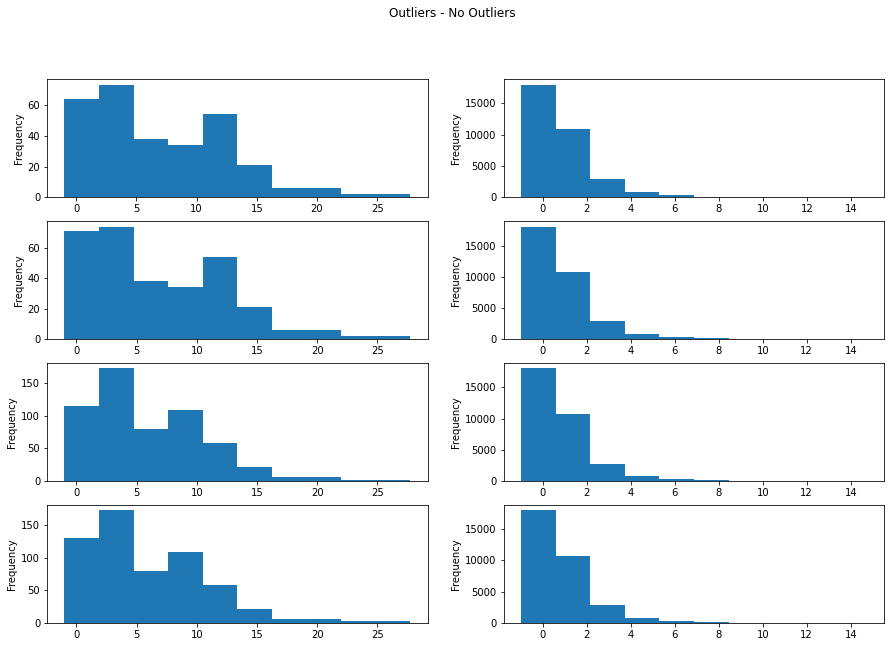

In [26]:
std_permutations = [(4,4), (3,4), (3,3), (2,3)]
volatile_outliers = plot_std('township_code', 'pct', std_permutations)

In [27]:
volatile_outliers[(2,3)]

,township_code,pin,year,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,lat,lon,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
149,77.0,16032160430000,2021.0,278,2021-07-19 00:00:00+00:00,397500.0,5.599337,7226615.0,2121725028,01,...,NaN,NaN,2122.0,2021.0,187.323280,0.002639,11.421875,1.131973,5.521533,0.077804
281,77.0,16234180270000,2022.0,204,2022-02-22 00:00:00+00:00,230000.0,5.361728,7304181.0,2205639015,01,...,NaN,NaN,1846.0,1903.0,124.593716,0.002905,6.931034,1.131973,5.521533,0.159805
514,72.0,20312250080000,2021.0,205,2021-10-06 00:00:00+00:00,269900.0,5.431203,7273313.0,2134912090,01,...,NaN,NaN,1658.0,1893.0,162.786490,0.003276,7.996667,1.867913,5.158363,0.272840
585,31.0,15143060120000,2021.0,211,2021-02-05 00:00:00+00:00,289000.0,5.460898,7153343.0,2106439176,01,...,NaN,NaN,1964.0,1920.0,147.148676,0.002780,5.601640,1.081472,5.316818,0.144080
967,71.0,13292140080000,2020.0,204,2020-07-01 00:00:00+00:00,325000.0,5.511883,97334007.0,2026212201,05,...,NaN,NaN,2054.0,1925.0,158.227848,0.002683,9.156250,0.670836,5.498897,0.012986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292625,19.0,22243060050000,2021.0,208,2021-11-03 00:00:00+00:00,402000.0,5.604226,7280716.0,2133501110,01,...,NaN,NaN,4923.0,1989.0,81.657526,0.001138,0.109731,0.419505,5.581725,0.022501
295256,20.0,12254100160000,2021.0,205,2021-07-20 00:00:00+00:00,625000.0,5.795880,7228673.0,2122134072,05,...,NaN,NaN,1801.0,1942.0,347.029428,0.003218,6.352941,0.699796,5.334347,0.461533
296752,72.0,20284110380000,2021.0,205,2021-09-20 00:00:00+00:00,285000.0,5.454845,7237409.0,2127342029,01,...,NaN,NaN,2016.0,1921.0,141.369048,0.002706,12.013104,1.867913,5.158363,0.296482
298831,24.0,10343090620000,2020.0,209,2020-07-01 00:00:00+00:00,1340000.0,6.127105,97333979.0,2026212198,02,...,NaN,NaN,5275.0,2019.0,254.028436,0.001162,2.769339,0.476809,5.484434,0.642670


## Growth Rates

In [28]:
dates = dups.groupby('pin')['sale_date'].agg(['first','last']).reset_index()

In [29]:
firsts = dates[['pin', 'first']].copy()
firsts.rename(columns= {'first': 'sale_date'}, inplace=True)
lasts = dates[['pin', 'last']].copy()
lasts.rename(columns= {'last': 'sale_date'}, inplace=True)

In [30]:
first_transactions = pd.merge(dups, firsts)
last_tranasactions = pd.merge(dups, lasts)

In [31]:
first_transactions[first_transactions.pin == 17293090360000]

,township_code,pin,year,class,sale_date,sale_price,sale_price_log10,sale_key,doc_no,deed_type,...,lat,lon,sqft,year_built,price_per_sqft,price_per_sqft_log10,pct,township_avg_change,township_mean_sale_log10,diff_from_township_mean_sale_log10
6415,76.0,17293090360000,2018.0,295,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,NaN,NaN,2328.0,2008.0,816.151203,0.002697,NaN,0.460942,5.388322,0.890432
6416,76.0,17293090360000,2018.0,295,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,NaN,NaN,2273.0,2008.0,835.899692,0.002762,0.0,0.460942,5.388322,0.890432
6417,76.0,17293090360000,2018.0,295,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,NaN,NaN,2328.0,2005.0,816.151203,0.002697,0.0,0.460942,5.388322,0.890432
6418,76.0,17293090360000,2018.0,295,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,NaN,NaN,2178.0,2005.0,872.359963,0.002883,0.0,0.460942,5.388322,0.890432
6419,76.0,17293090360000,2018.0,295,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,NaN,NaN,2273.0,2005.0,835.899692,0.002762,0.0,0.460942,5.388322,0.890432
6420,76.0,17293090360000,2018.0,295,2018-06-01 00:00:00+00:00,1900000.0,6.278754,98003615.0,1818349528,05,...,NaN,NaN,2178.0,2008.0,872.359963,0.002883,0.0,0.460942,5.388322,0.890432


In [32]:
t = last_tranasactions.pin.value_counts()
last_tranasactions = last_tranasactions[last_tranasactions.pin.isin(t.index[~t.gt(1)])]
t = first_transactions.pin.value_counts()
first_transactions = first_transactions[first_transactions.pin.isin(t.index[~t.gt(1)])]

In [33]:
transactions = pd.concat([first_transactions, last_tranasactions], ignore_index=True)

In [34]:
transactions.drop(columns=['pct'], axis=1, inplace=True)
transactions['total_pct'] = transactions.sort_values('sale_date').groupby('pin')['sale_price'].pct_change()
transactions.total_pct.mean()

1.0703044486068327

In [35]:
transactions.total_pct.describe()

count    30455.000000
mean         1.070304
std          1.577306
min         -0.987693
25%          0.145130
50%          0.547128
75%          1.392752
max         27.750000
Name: total_pct, dtype: float64

In [36]:
transactions[transactions.township_code == 76].total_pct.describe()

count    445.000000
mean       0.548682
std        1.054846
min       -0.462963
25%        0.026052
50%        0.155882
75%        0.600000
max       11.235294
Name: total_pct, dtype: float64

In [37]:
"""
transactions = transactions[transactions.pin != 17153040641207]
transactions = transactions[transactions.pin != 17153040641003]
transactions = transactions[transactions.pin != 17153040641141]
transactions = transactions[transactions.pin != 17153040641012]
transactions = transactions[transactions.pin != 17153040641112]
transactions = transactions[transactions.pin != 17153040641195]
transactions = transactions[transactions.pin != 17153040641208]
transactions = transactions[transactions.pin != 17153040641209]
transactions = transactions[transactions.pin != 17153040641010]
transactions = transactions[transactions.pin != 17153040641007]
transactions = transactions[transactions.pin != 17153040641113]
transactions = transactions[transactions.pin != 17153040641135]
transactions = transactions[transactions.pin != 17153040641145]
transactions = transactions[transactions.pin != 17153040641023]
transactions = transactions[transactions.pin != 17153040641062]
transactions = transactions[transactions.pin != 17153040641020]
transactions = transactions[transactions.pin != 17153040641002]
transactions = transactions[transactions.pin != 17153040641144]
transactions = transactions[transactions.pin != 17153040641139]
transactions = transactions[transactions.pin != 17153040641126]
transactions = transactions[transactions.pin != 17153040641074]
transactions = transactions[transactions.pin != 17153040641015]
transactions = transactions[transactions.pin != 17153040641095]
transactions = transactions[transactions.pin != 17153040641125]
transactions = transactions[transactions.pin != 17153040641014]
transactions = transactions[transactions.pin != 17153040641080]
transactions = transactions[transactions.pin != 17153040641089]
transactions = transactions[transactions.pin != 17153040641155]
transactions = transactions[transactions.pin != 17153040641072]
# PINS map to same property

transactions = transactions[transactions.pin != 9154010240000]
transactions = transactions[transactions.pin != 9154010240000]
"""

'\ntransactions = transactions[transactions.pin != 17153040641207]\ntransactions = transactions[transactions.pin != 17153040641003]\ntransactions = transactions[transactions.pin != 17153040641141]\ntransactions = transactions[transactions.pin != 17153040641012]\ntransactions = transactions[transactions.pin != 17153040641112]\ntransactions = transactions[transactions.pin != 17153040641195]\ntransactions = transactions[transactions.pin != 17153040641208]\ntransactions = transactions[transactions.pin != 17153040641209]\ntransactions = transactions[transactions.pin != 17153040641010]\ntransactions = transactions[transactions.pin != 17153040641007]\ntransactions = transactions[transactions.pin != 17153040641113]\ntransactions = transactions[transactions.pin != 17153040641135]\ntransactions = transactions[transactions.pin != 17153040641145]\ntransactions = transactions[transactions.pin != 17153040641023]\ntransactions = transactions[transactions.pin != 17153040641062]\ntransactions = transac

<AxesSubplot:ylabel='Frequency'>

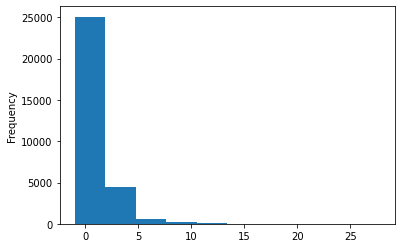

In [43]:
transactions.total_pct.plot.hist()

In [39]:
transactions.groupby('township_code')['total_pct'].mean()

township_code
10.0    0.374418
11.0    1.020474
12.0    1.467673
13.0    0.955112
14.0    2.262407
15.0    1.558235
16.0    0.448555
17.0    0.483216
18.0    0.443711
19.0    0.432998
20.0    0.716877
21.0    0.708175
22.0    0.556339
23.0    0.623903
24.0    0.498016
25.0    0.549473
26.0    0.592302
27.0    0.504758
28.0    0.382529
29.0    0.329384
30.0    0.686520
31.0    1.148819
32.0    1.279650
33.0    0.309286
34.0    0.666732
35.0    0.369694
36.0    1.003759
37.0    1.828558
38.0    0.435760
39.0    0.804520
70.0    2.105898
71.0    0.716096
72.0    2.029013
73.0    0.284184
74.0    0.230078
75.0    0.418401
76.0    0.548682
77.0    1.310667
Name: total_pct, dtype: float64

In [40]:
transactions.groupby('census_tract_geoid')['total_pct'].mean()

census_tract_geoid
1.703180e+10    0.577508
1.703180e+10    0.843546
1.703180e+10    0.383238
1.703180e+10    0.294556
1.703180e+10    0.540205
                  ...   
1.703181e+10    0.313948
1.703181e+10    0.896171
1.703181e+10    0.578984
1.703181e+10    0.251956
1.703181e+10    0.258206
Name: total_pct, Length: 153, dtype: float64